In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

1.14.0


In [0]:
# Fixed for our bed, chair, lamp and wardrobe classes
NUM_CLASSES = 4

# Fixed for color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [0]:
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 4-class classification, i.e., bed, chair, lamp or wardrobe using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [31]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input
                                    )

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have (NUM_CLASSES) sub-folders
train_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/furniture_classification/dataset/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/furniture_classification/dataset/val',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 2354 images belonging to 4 classes.
Found 294 images belonging to 4 classes.


In [0]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/furniture_classification/weights/resnet50_furniture.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [33]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
)

Epoch 1/10
10/10 [==============================] - 143s 14s/step - loss: 0.0650 - acc: 0.9801 - val_loss: 0.2553 - val_acc: 0.9175
Epoch 2/10
10/10 [==============================] - 76s 8s/step - loss: 0.0778 - acc: 0.9810 - val_loss: 0.2131 - val_acc: 0.9196
Epoch 3/10
10/10 [==============================] - 127s 13s/step - loss: 0.0595 - acc: 0.9822 - val_loss: 0.1850 - val_acc: 0.9450
Epoch 4/10
10/10 [==============================] - 89s 9s/step - loss: 0.0383 - acc: 0.9920 - val_loss: 0.2019 - val_acc: 0.9358
Epoch 5/10
10/10 [==============================] - 105s 11s/step - loss: 0.0522 - acc: 0.9906 - val_loss: 0.2333 - val_acc: 0.9206
Epoch 6/10
10/10 [==============================] - 99s 10s/step - loss: 0.0396 - acc: 0.9920 - val_loss: 0.1897 - val_acc: 0.9379
Epoch 7/10
10/10 [==============================] - 65s 7s/step - loss: 0.0391 - acc: 0.9940 - val_loss: 0.1917 - val_acc: 0.9348
Epoch 8/10
10/10 [==============================] - 136s 14s/step - loss: 0.0331 - 

In [0]:
model.load_weights("/content/drive/My Drive/furniture_classification/weights/resnet50_furniture.h5")

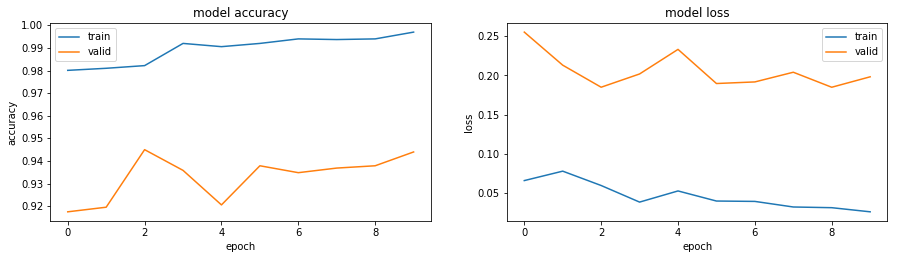

In [35]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [36]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = '/content/drive/My Drive/furniture_classification/dataset/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 297 images belonging to 4 classes.


In [37]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

297/297 [==============================] - 22s 73ms/step


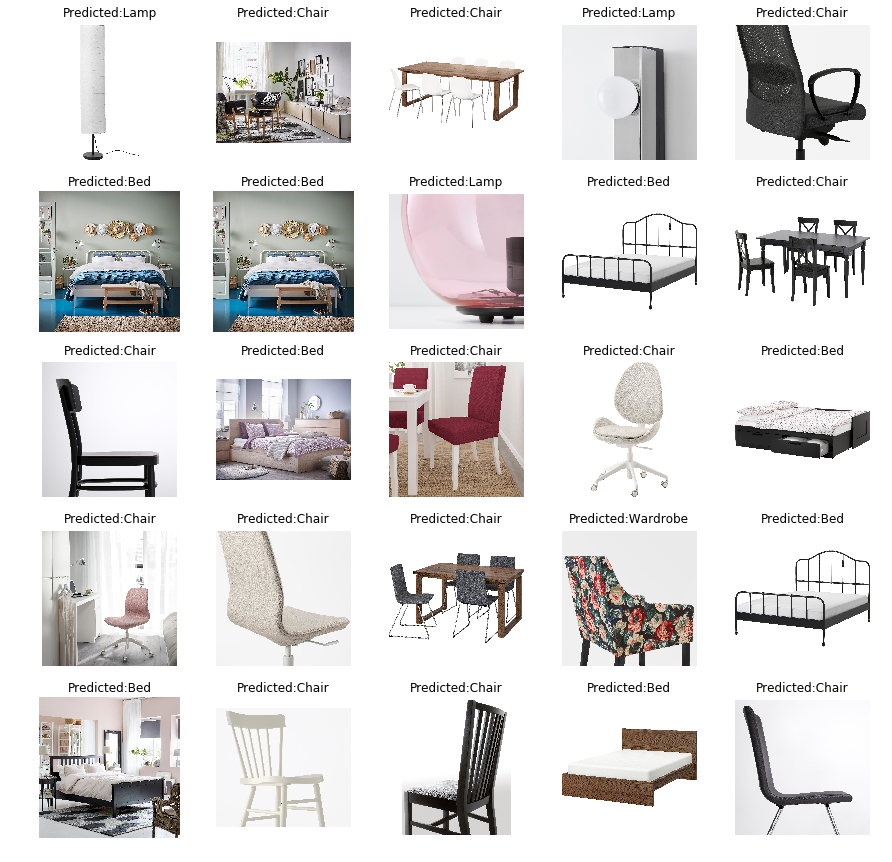

In [38]:
import random
np.random.seed(1)

TEST_DIR = '/content/drive/My Drive/furniture_classification/dataset/test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

# print(len(test_generator.filenames))

for i in range(0,25):
  j=random.randint(0,197)
#   print(TEST_DIR + test_generator.filenames[random.randint(0,198)])
  imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[j])
  imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

  # a if condition else b
#   predicted_class = "Dog" if predicted_class_indices[i] else "Cat"
#   print(predicted_class_indices)
  if predicted_class_indices[j]==0:
    predicted_class = "Bed"
  elif predicted_class_indices[j]==1:
    predicted_class = "Chair"
  elif predicted_class_indices[j]==2:
    predicted_class = "Lamp"
  elif predicted_class_indices[j]==3:
    predicted_class = "Wardrobe"
    

  ax[i//5, i%5].imshow(imgRGB)
  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))
  ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))


plt.show()

In [0]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, predicted_class_indices)

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

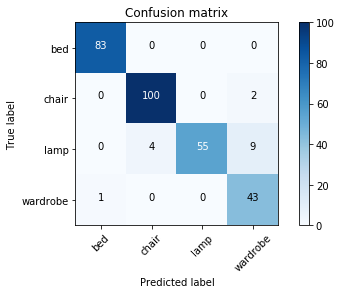

In [42]:
plot_confusion_matrix(cm,class_labels)